<a href="https://colab.research.google.com/github/harshavardhangadila/Basic-Neural-Network-Using-Numpy-Keras-Pytorch-and-Jax/blob/main/11)_Neural_Network_using_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade -q jax jaxlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 104.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.1 which is incompatible.


In [2]:
# Step 2: Import JAX and others
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap, value_and_grad
from jax.tree_util import tree_flatten, tree_unflatten, tree_map
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.6.0, so it will not be used.
  warnings.warn(


In [3]:
# Step 3: Set JAX PRNG key
key = random.PRNGKey(0)

In [4]:
# Step 4: Generate synthetic 3-variable regression data
def generate_data(n_samples=1000, key=None):
    if key is None:
        key = random.PRNGKey(42)
    x1 = random.uniform(key, (n_samples,), minval=-5, maxval=5)
    x2 = random.uniform(key + 1, (n_samples,), minval=-5, maxval=5)
    x3 = random.uniform(key + 2, (n_samples,), minval=-5, maxval=5)
    y = 2 * jnp.sin(x1) + 0.5 * x2**2 + 0.3 * x3**3 + jnp.cos(x1 * x2)
    y += 0.2 * random.normal(key + 3, (n_samples,))
    X = jnp.stack([x1, x2, x3], axis=1)
    y = y.reshape(-1, 1)
    return X, y

In [5]:
# Step 5: Create training data
X, y = generate_data(1000, key)

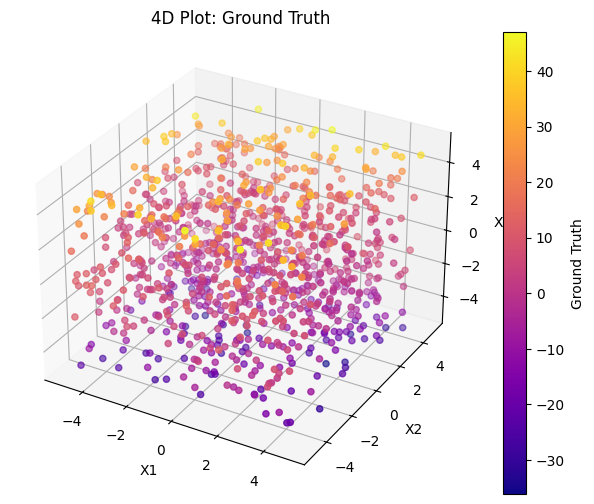

In [6]:
# Step 6: Visualize data in 4D
def plot_4d(X, y, label="Target"):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(np.array(X[:, 0]), np.array(X[:, 1]), np.array(X[:, 2]), c=np.array(y).squeeze(), cmap='plasma')
    plt.colorbar(sc, label=label)
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.set_zlabel("X3")
    ax.set_title(f"4D Plot: {label}")
    plt.show()

plot_4d(X, y, "Ground Truth")

In [7]:
# Step 7: He Initialization Function
def he_init(key, shape):
    return random.normal(key, shape) * jnp.sqrt(2.0 / shape[0])

In [8]:
# Step 8 Initialize weights
k1, k2, k3, k4, k5, k6 = random.split(key, 6)
params = {
    "W1": he_init(k1, (3, 128)),
    "b1": jnp.zeros((128,)),
    "W2": he_init(k2, (128, 64)),
    "b2": jnp.zeros((64,)),
    "W3": he_init(k3, (64, 1)),
    "b3": jnp.zeros((1,))
}

In [9]:
# Step 9 Define ReLU activation
def relu(x): return jnp.maximum(x, 0)

In [10]:
# Step 10: Forward pass function
def forward(params, X):
    z1 = jnp.dot(X, params["W1"]) + params["b1"]
    a1 = relu(z1)
    z2 = jnp.dot(a1, params["W2"]) + params["b2"]
    a2 = relu(z2)
    out = jnp.dot(a2, params["W3"]) + params["b3"]
    return out

In [11]:
# Step 11: Batch inference
@jit
def predict(params, X):
    return forward(params, X)


In [12]:
# Step 12: Define loss function
def mse_loss(params, X, y):
    y_hat = forward(params, X)
    return jnp.mean((y - y_hat)**2)

In [14]:
# Step 13: Gradient function
grad_fn = jit(grad(mse_loss))

In [15]:
# Step 14: Parameter update function
@jit
def update(params, X, y, lr=0.001):
    grads = grad_fn(params, X, y)
    return tree_map(lambda p, g: p - lr * g, params, grads)

In [16]:
# Step 15: Training setup
epochs = 1000
lr = 0.001
losses = []

In [17]:
# Step 16: Training loop
for epoch in range(epochs):
    loss = mse_loss(params, X, y)
    losses.append(loss)
    params = update(params, X, y, lr)
    if epoch % 100 == 0 or epoch < 5:
        print(f"Epoch {epoch}, Loss: {loss:.5f}")

Epoch 0, Loss: 214.69260
Epoch 1, Loss: 122.57648
Epoch 2, Loss: 79.16039
Epoch 3, Loss: 55.30598
Epoch 4, Loss: 44.09011
Epoch 100, Loss: 24.40593
Epoch 200, Loss: 21.71418
Epoch 300, Loss: 20.52555
Epoch 400, Loss: 19.37155
Epoch 500, Loss: 18.60146
Epoch 600, Loss: 17.99086
Epoch 700, Loss: 17.33336
Epoch 800, Loss: 16.77513
Epoch 900, Loss: 16.02481


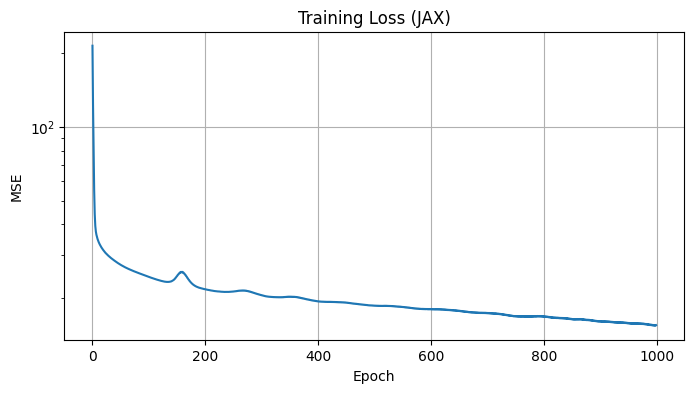

In [18]:
# Step 17: Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.yscale("log")
plt.title("Training Loss (JAX)")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

In [19]:
# Step 18: Make predictions
y_pred = predict(params, X)

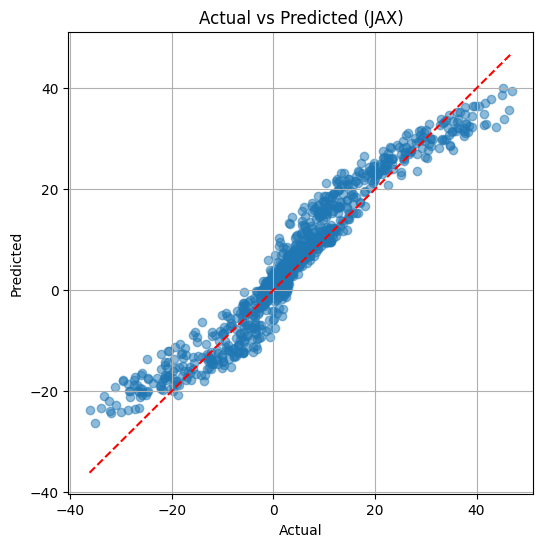

In [20]:
# Step 19: Actual vs predicted
plt.figure(figsize=(6, 6))
plt.scatter(np.array(y), np.array(y_pred), alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted (JAX)")
plt.grid(True)
plt.show()

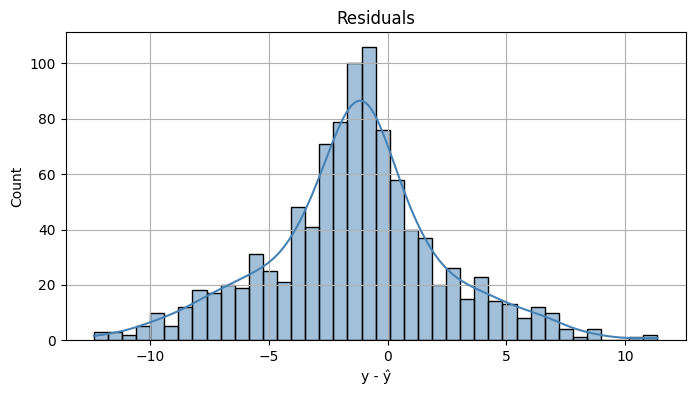

In [21]:
# Step 20: Residuals
residuals = np.array(y - y_pred).flatten()
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=40, kde=True, color='steelblue')
plt.title("Residuals")
plt.xlabel("y - ŷ")
plt.grid(True)
plt.show()

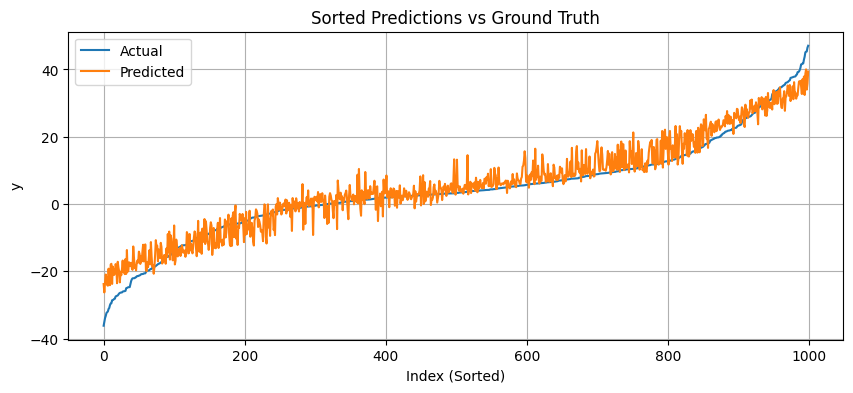

In [22]:
# Step 21: Sorted prediction vs target
sorted_idx = np.argsort(np.array(y)[:, 0])
plt.figure(figsize=(10, 4))
plt.plot(np.array(y)[sorted_idx], label='Actual')
plt.plot(np.array(y_pred)[sorted_idx], label='Predicted')
plt.title("Sorted Predictions vs Ground Truth")
plt.xlabel("Index (Sorted)")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Step 22: Custom input prediction
def predict_point(x1, x2, x3):
    x = jnp.array([[x1, x2, x3]], dtype=jnp.float32)
    return float(forward(params, x)[0, 0])

test_pts = [(-3, -3, -3), (0, 0, 0), (3, 3, 3)]
for x1, x2, x3 in test_pts:
    pred = predict_point(x1, x2, x3)
    actual = float(2 * np.sin(x1) + 0.5 * x2**2 + 0.3 * x3**3 + np.cos(x1 * x2))
    print(f"Input: ({x1}, {x2}, {x3}) → Pred: {pred:.3f}, Actual: {actual:.3f}")

Input: (-3, -3, -3) → Pred: -6.781, Actual: -4.793
Input: (0, 0, 0) → Pred: -0.181, Actual: 1.000
Input: (3, 3, 3) → Pred: 19.753, Actual: 11.971


In [24]:
# Step 23: Compute RMSE
rmse = jnp.sqrt(jnp.mean((y - y_pred)**2))
print(f"\nFinal RMSE: {rmse:.4f}")


Final RMSE: 3.9234


In [25]:
# Step 24: Per-sample gradients (advanced)
def loss_per_sample(params, X, y):
    def single_loss(x, y_true): return jnp.mean((forward(params, x[None, :]) - y_true) ** 2)
    return vmap(single_loss)(X, y)

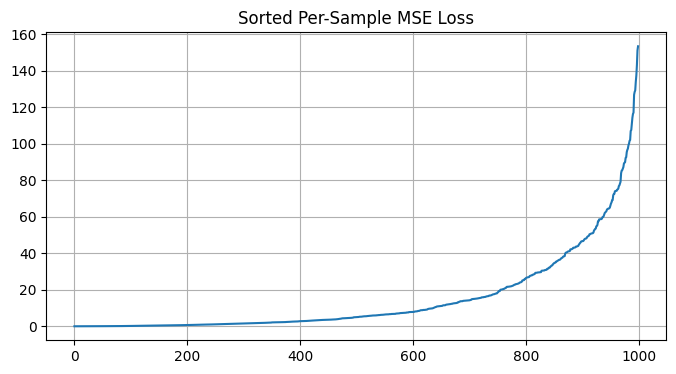

In [26]:
# Step 25: Visualize per-sample loss
sample_losses = loss_per_sample(params, X, y)
plt.figure(figsize=(8, 4))
plt.plot(np.sort(np.array(sample_losses)))
plt.title("Sorted Per-Sample MSE Loss")
plt.grid(True)
plt.show()

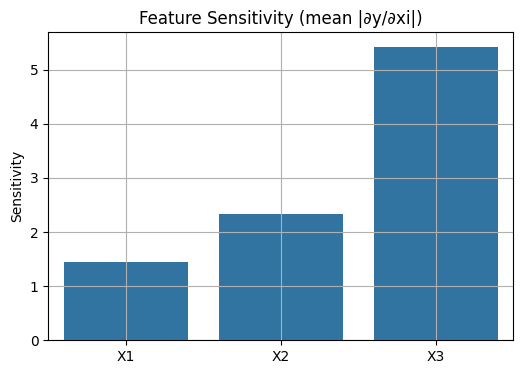

In [28]:
# Step 26: Feature sensitivity via gradient magnitude
@jit
def feature_sensitivity(params, X):
    def single_input_sensitivity(x):
        # Compute ∂(forward output)/∂x for a single x
        def scalar_output(xi):
            return forward(params, xi[None, :])[0, 0]  # scalar output
        return grad(scalar_output)(x)
    return vmap(single_input_sensitivity)(X)  # shape: [n_samples, input_dim]

grads = feature_sensitivity(params, X)  # shape: [1000, 3]
sensitivity = jnp.mean(jnp.abs(grads), axis=0)  # mean over samples

# Plot feature sensitivity
plt.figure(figsize=(6, 4))
sns.barplot(x=["X1", "X2", "X3"], y=np.array(sensitivity))
plt.title("Feature Sensitivity (mean |∂y/∂xi|)")
plt.ylabel("Sensitivity")
plt.grid(True)
plt.show()

In [29]:
# Step 27: Flatten/Unflatten model (tree_util)
flat_params, tree_def = tree_flatten(params)
print(f"Total trainable tensors: {len(flat_params)}")

Total trainable tensors: 6


In [30]:
# Step 28: JIT compile forward
compiled_forward = jit(forward)
_ = compiled_forward(params, X[:10])

In [31]:
# Step 29: Save predictions
import pandas as pd
df = pd.DataFrame(np.array(X), columns=["X1", "X2", "X3"])
df["Actual"] = y.flatten()
df["Predicted"] = y_pred.flatten()
df["Residual"] = df["Actual"] - df["Predicted"]
df.to_csv("jax_final_predictions.csv", index=False)

In [32]:
# Step 30: Show sample predictions
print("\nSample predictions:")
print(df.head(5))


Sample predictions:
         X1        X2        X3     Actual  Predicted  Residual
0  4.476670  2.086607  1.776997   0.909025   2.816948 -1.907923
1  4.785799  3.031444  0.856100   2.286703   4.659472 -2.372768
2 -1.677085  0.565329 -3.872641 -18.840124 -20.716465  1.876341
3 -0.313315  0.252624 -2.367611  -3.390197 -11.049770  7.659574
4  0.698887 -4.959149  4.586390  41.489750  34.922691  6.567059
